<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/Feature_Selection_Variance_Threshold_LGBMClassifier_on_agg_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import gc 

import numpy as np
import pandas as pd
import lightgbm as gbm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_classif, RFECV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_parquet(path='/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 920 entries, customer_ID to target
dtypes: float64(891), int64(26), object(3)
memory usage: 3.1+ GB


In [4]:
columns = df.head().dtypes
columns[columns==object]


customer_ID    object
D_63_last      object
D_64_last      object
dtype: object

In [5]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [6]:
X = pd.DataFrame()
Y = pd.DataFrame()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10)
df[['D_63_last', 'D_64_last']]=enc.fit(df[['D_63_last', 'D_64_last']])
df[['D_63_last', 'D_64_last']]=enc.transform(df[['D_63_last', 'D_64_last']])
df.fillna(0, inplace=True)
X= X.append(df.loc[:, ~df.columns.isin(['customer_ID', 'target'])])
Y = Y.append(df.loc[:, df.columns == 'target'])

In [7]:
#clf = gbm.LGBMClassifier(subsample=0.8, colsample_bytree=0.6)
clf = gbm.LGBMClassifier()

In [8]:
sfs = VarianceThreshold()

In [9]:
sfs = sfs.fit(X)

In [10]:
concol = [column for column in X.columns 
          if column not in X.columns[sfs.get_support()]]
len(concol)

3

In [11]:
for features in concol:
    print(features)

D_87_std
D_63_last
D_64_last


In [12]:
X.D_64_last.unique()

array([10.])

In [13]:
X = sfs.transform(X)

In [14]:
X.shape

(458913, 915)

In [15]:
 X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [16]:
clf.fit(X_train, y_train.values.ravel())

LGBMClassifier()

In [17]:
clf.score(X_test, y_test)

0.9003519170216707

In [18]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [19]:
y_pred = clf.predict(X_test)

In [20]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [21]:
tn, fp, fn, tp

(63568, 4583, 4563, 19069)

In [22]:
f1_score(y_test, y_pred)

0.8065730479654851

In [27]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9330    0.9328    0.9329     68151
           1     0.8062    0.8069    0.8066     23632

    accuracy                         0.9004     91783
   macro avg     0.8696    0.8698    0.8697     91783
weighted avg     0.9004    0.9004    0.9004     91783



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


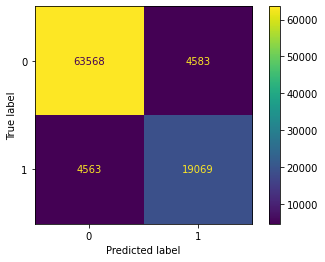

In [29]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()



*   TN = Non defaulting customer and my model predicted that customer won't default.
*   FP = Non defaulting customer but my model predicted that the customer will default.
*   FN = Customer defaulted but my model predicted that the customer will not default.
*   TP = Customer defaulted and my model predicted customer will default.

